In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = '../data/'
from matplotlib.colors import ListedColormap
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsClassifier as KNN

In [2]:
df = pd.read_csv(DATA_DIR + 'Skin_NonSkin.txt', delimiter="\t", header=None)

In [3]:
df.columns = ["B","G","R","Class"]
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245057 entries, 0 to 245056
Data columns (total 4 columns):
B        245057 non-null int64
G        245057 non-null int64
R        245057 non-null int64
Class    245057 non-null int64
dtypes: int64(4)
memory usage: 9.3 MB


,B,G,R,Class
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


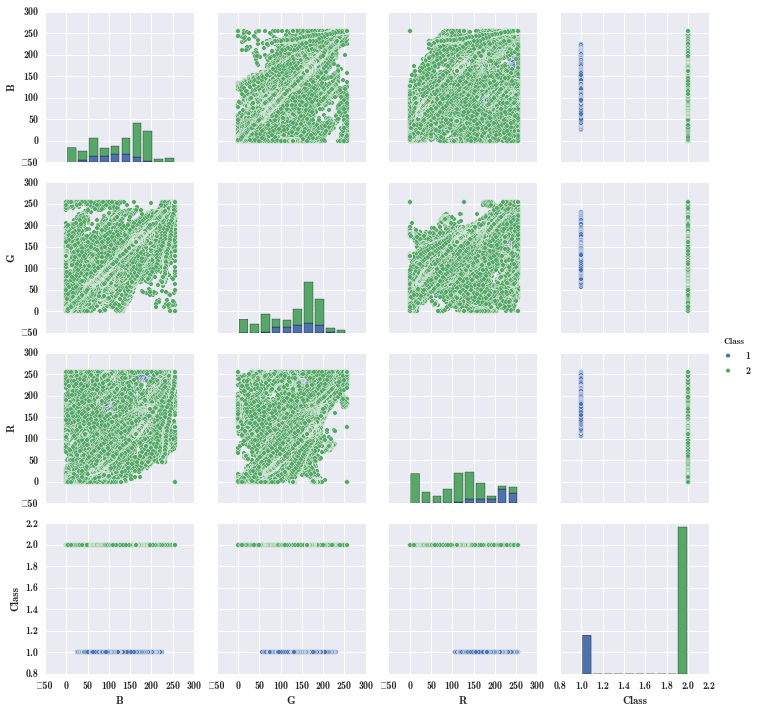

In [35]:
#
# Do a scatter plot of the raw data
#
sns.pairplot(df, hue="Class", size=2.5);

In [68]:
print len(df)
C1size=len(df[df.Class == 1])
C2size=len(df[df.Class == 2])
r = float(C1size) / C2size
X = df.ix[:,:-1]
y = df.ix[:,-1]
print y.value_counts()
print r

#
# seems the number of samples for class 1 << class 2
#

245057
2    194198
1     50859
dtype: int64
0.261892501468


In [69]:
# number of sample for Class 1 <<  Class 2
# use sample size of Class 1 for training and testing
# random pick the min sample size for Class 2

from scipy.stats import itemfreq
idx1 = np.random.uniform(0, 1, C2size) < float(C1size)/C2size
print itemfreq(idx1)

[[     0 143109]
 [     1  51089]]


In [70]:
C2 = df[df.Class == 2]
C1 = df[df.Class == 1]

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1292: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1292: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=9.35. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


101948 101948


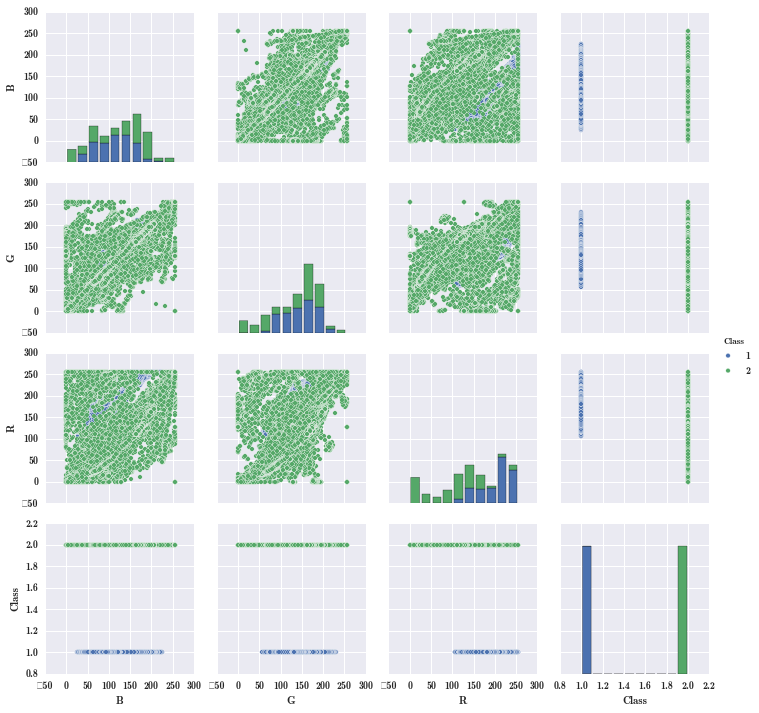

In [71]:
#
# Make a new set of data
#
ndf = C1.append(C2[idx1])

#
# Do a scatter plot of the new dataset
#
sns.pairplot(ndf, hue="Class", size=2.5);
X = ndf.ix[:,:-1]
y = ndf.ix[:,-1]
print len(X), len(y)

In [72]:
#
# Mart's method of doing the train/test split
#

idx = np.random.uniform(0, 1, len(X)) >= 0.3
X_train, X_test = X[idx], X[idx==False]
y_train, y_test = y[idx], y[idx==False]

In [73]:
y_test.value_counts()

1    15316
2    15269
dtype: int64

In [74]:
# use the built-in method from SciKit-Learn
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.30)

In [75]:
n_neighbors = range(1,31,2)

In [76]:
# Loop through each neighbors value and append
# the scores
scores = []
for n in n_neighbors:
    clf = KNN(n)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
scores

[0.99970573810691521,
 0.99960765080922021,
 0.99941147621383031,
 0.99931338891613541,
 0.99921530161844041,
 0.99911721432074552,
 0.99908451855484715,
 0.99898643125715225,
 0.99892103972535562,
 0.99862677783227072,
 0.99852869053457582,
 0.99849599476867745,
 0.99846329900277919,
 0.99826712440738929,
 0.99826712440738929]

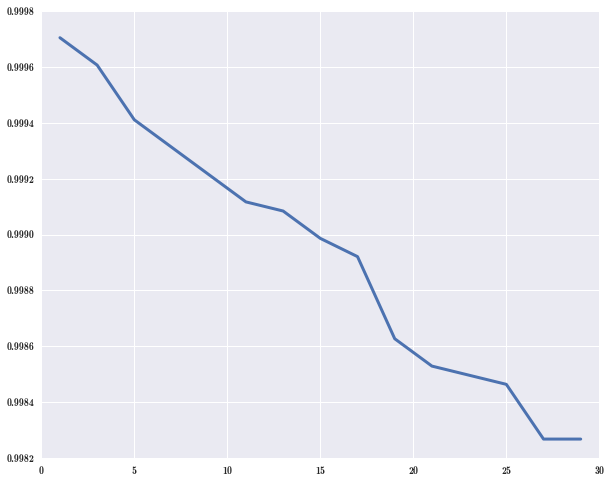

In [77]:
plt.figure(figsize=(10,8))
plt.plot(n_neighbors, scores, linewidth=3.0)
plt.show()
#
# looks like k < 5 is good enough
#

In [330]:
### with cross validation
### by doing different train/test split

In [78]:
scores = []
all = []
idx = np.random.uniform(0, 1, len(X)) >= 0.3
for i in range(5):
    np.random.shuffle(idx)
    X_train, X_test = X[idx], X[idx == False]
    y_train, y_test = y[idx], y[idx == False]
    for n in n_neighbors:
        clf = KNN(n, weights='uniform')
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    all.append(scores)
    scores

In [79]:
np.mean(all)

0.99868476265407813

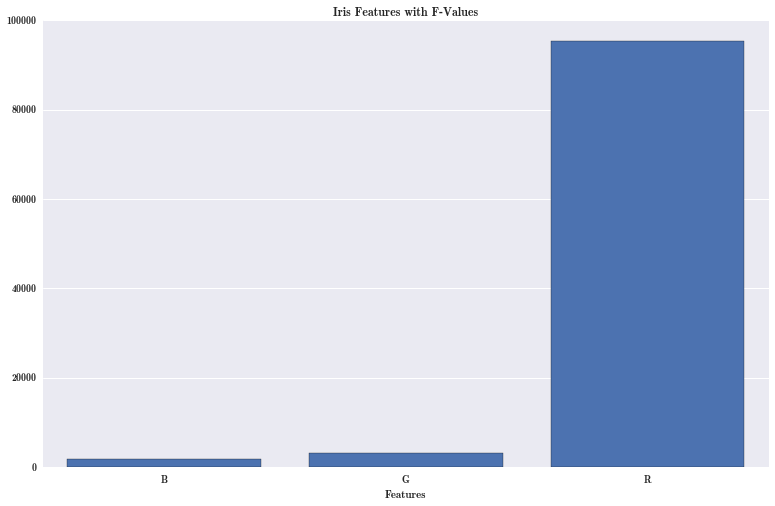

In [80]:
#
# Use F statistics to see what features are dominating
#

F = feature_selection.f_classif(X, y)[0]
title = 'BGR Features with F-Values'

plt.figure(figsize=(13, 8))
ax = sns.barplot(x=df.columns[:-1],y=F)
ax.set_title(title)
ax.set(xlabel="Features");

In [81]:
#
# R is the dominant feature
# but we select both G and R in X as feature
#
X_ = X.ix[:, -2:].values
a = list(y.unique())
y_ = [a.index(v) for v in y]

In [82]:
#
# Do the knn again with k=11
#
clf = KNN(11, weights='uniform')
clf.fit(X_, y_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=11, p=2, weights='uniform')

In [83]:
x_min, x_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
y_min, y_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1

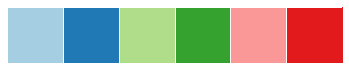

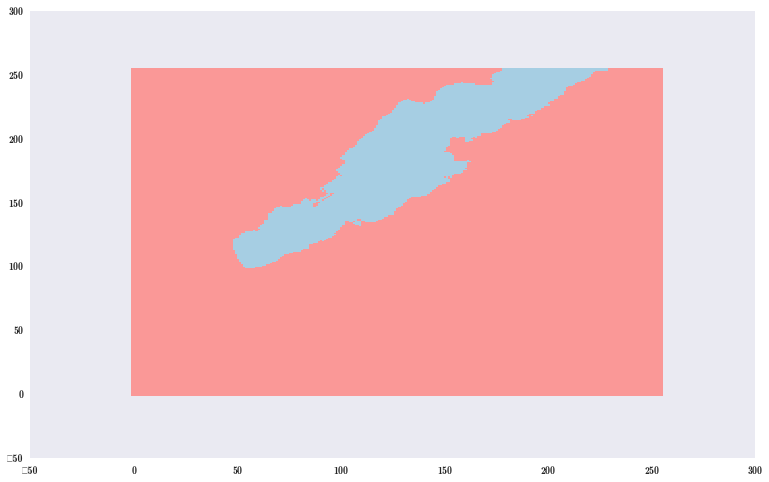

In [84]:
h = 1  # step size in the mesh
#
# Create color maps
#
col_map = sns.color_palette("Paired")
sns.palplot(col_map)
cmap_light = ListedColormap(['#A6CEE3', '#AFDD8A', '#FA9897'])
cmap_bold = ListedColormap(['#2078B4', '#35A12E', '#E31A1C'])
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
from matplotlib.pyplot import pcolormesh
plt.figure(figsize=(13,8))
pcolormesh(xx, yy, Z, cmap=cmap_light);

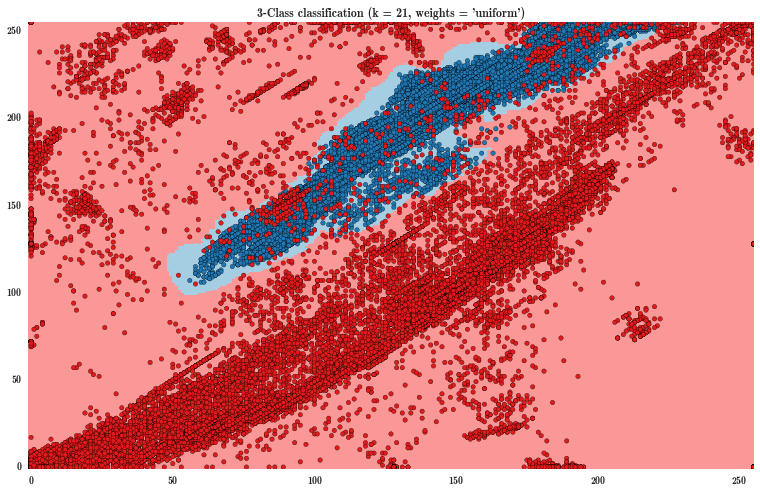

In [85]:
#
# Plot also the training points
#
plt.figure(figsize=(13,8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i, weights = '%s')"
         % (21, 'uniform'));

In [86]:
clf.predict([162,112])

array([1])

In [87]:
clf.predict([85,125])

array([0])